In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# filtering on icd 9 codes

# Extract Transplant Patients from PROCEDURES_ICD
# Load ICD procedure codes and admissions
procedures = pd.read_csv("PROCEDURES_ICD.csv")
admissions = pd.read_csv("ADMISSIONS.csv")
patients = pd.read_csv("PATIENTS.csv")

# Identify transplant procedures — ICD-9 codes start with:
# '33' (lung), '41' (heart), '50' (liver/kidney), etc.
transplant_prefixes = ('33', '41', '50')
is_transplant = procedures['ICD9_CODE'].astype(str).str.startswith(transplant_prefixes)

# Extract transplant hospital admissions
transplant_hadm_ids = procedures[is_transplant]['HADM_ID'].unique()

# Join with ADMISSIONS and PATIENTS for demographics
transplant_df = admissions[admissions['HADM_ID'].isin(transplant_hadm_ids)]
transplant_df = transplant_df.merge(patients, on='SUBJECT_ID')

transplant_df.shape


(7950, 26)

In [3]:
# Feature Engineering — Demographics
# Age
transplant_df['ADMITTIME'] = pd.to_datetime(transplant_df['ADMITTIME'])
transplant_df['DOB'] = pd.to_datetime(transplant_df['DOB'])
transplant_df['AGE'] = transplant_df['ADMITTIME'].dt.year - transplant_df['DOB'].dt.year
transplant_df['AGE'] = transplant_df['AGE'].clip(lower=0, upper=100)  # handle edge cases

# Select features
features = transplant_df[['HADM_ID', 'SUBJECT_ID', 'AGE', 'GENDER', 'ETHNICITY']].copy()
features = pd.get_dummies(features, columns=['GENDER', 'ETHNICITY'], drop_first=True)


In [4]:

'''
# Add Lab Features (Creatinine, WBC, Hematocrit)
labevents = pd.read_csv("LABEVENTS.csv")

lab_items = {
    'CREATININE': 50912,
    'WBC': 51300,
    'HEMATOCRIT': 51221
}

lab_df = labevents[
    (labevents['ITEMID'].isin(lab_items.values())) &
    (labevents['HADM_ID'].isin(features['HADM_ID']))
]

# Median lab values per hospital stay
lab_summary = lab_df.groupby(['HADM_ID', 'ITEMID'])['VALUENUM'].median().unstack().reset_index()
lab_summary.columns = ['HADM_ID'] + [f'LAB_{k}' for k in lab_items.keys()]

features = features.merge(lab_summary, on='HADM_ID', how='left').dropna()
'''

'\n# Add Lab Features (Creatinine, WBC, Hematocrit)\nlabevents = pd.read_csv("LABEVENTS.csv")\n\nlab_items = {\n    \'CREATININE\': 50912,\n    \'WBC\': 51300,\n    \'HEMATOCRIT\': 51221\n}\n\nlab_df = labevents[\n    (labevents[\'ITEMID\'].isin(lab_items.values())) &\n    (labevents[\'HADM_ID\'].isin(features[\'HADM_ID\']))\n]\n\n# Median lab values per hospital stay\nlab_summary = lab_df.groupby([\'HADM_ID\', \'ITEMID\'])[\'VALUENUM\'].median().unstack().reset_index()\nlab_summary.columns = [\'HADM_ID\'] + [f\'LAB_{k}\' for k in lab_items.keys()]\n\nfeatures = features.merge(lab_summary, on=\'HADM_ID\', how=\'left\').dropna()\n'

In [5]:
# demographics 
patients = pd.read_csv("PATIENTS.csv", usecols=["SUBJECT_ID", "GENDER", "DOB"])
admissions = pd.read_csv("ADMISSIONS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "ETHNICITY", "HOSPITAL_EXPIRE_FLAG"])

# Merge to transplant_df
#demo = transplant_df.merge(admissions, on=["SUBJECT_ID", "HADM_ID"], how="left").merge(patients, on="SUBJECT_ID", how="left")

In [6]:
'''# Make a copy of the transplant df
demo = transplant_df.copy()
# Ensure datetime types
demo["ADMITTIME"] = pd.to_datetime(demo["ADMITTIME"], errors="coerce")
demo["DISCHTIME"] = pd.to_datetime(demo["DISCHTIME"], errors="coerce")
demo["DOB"] = pd.to_datetime(demo["DOB"], errors="coerce")

# Remove rows with clearly invalid DOBs or missing dates
demo = demo[
    (demo["DOB"].notna()) &
    (demo["ADMITTIME"].notna()) &
    (demo["DISCHTIME"].notna()) &
    (demo["DOB"] > pd.to_datetime("1900-01-01")) & 
    (demo["DOB"] < demo["ADMITTIME"])
]

# Now calculate age and length of stay
demo["age"] = (demo["ADMITTIME"] - demo["DOB"]).dt.days / 365.25
demo["los"] = (demo["DISCHTIME"] - demo["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)


# Convert to datetime and coerce errors
demo["ADMITTIME"] = pd.to_datetime(demo["ADMITTIME"], errors="coerce")
demo["DOB"] = pd.to_datetime(demo["DOB"], errors="coerce")
demo["DISCHTIME"] = pd.to_datetime(demo["DISCHTIME"], errors="coerce")

# Drop rows with any missing or failed date conversions
demo = demo.dropna(subset=["ADMITTIME", "DOB", "DISCHTIME"])

# Drop rows with clearly bad dates
demo = demo[
    (demo["DOB"] > pd.Timestamp("1900-01-01")) & 
    (demo["DOB"] < pd.Timestamp("2025-01-01")) &  # filter out future dates
    (demo["DOB"] < demo["ADMITTIME"]) & 
    (demo["ADMITTIME"] < demo["DISCHTIME"])
]
print(demo["DOB"].sort_values().head(10))
print(demo["DOB"].sort_values().tail(10))'''

'# Make a copy of the transplant df\ndemo = transplant_df.copy()\n# Ensure datetime types\ndemo["ADMITTIME"] = pd.to_datetime(demo["ADMITTIME"], errors="coerce")\ndemo["DISCHTIME"] = pd.to_datetime(demo["DISCHTIME"], errors="coerce")\ndemo["DOB"] = pd.to_datetime(demo["DOB"], errors="coerce")\n\n# Remove rows with clearly invalid DOBs or missing dates\ndemo = demo[\n    (demo["DOB"].notna()) &\n    (demo["ADMITTIME"].notna()) &\n    (demo["DISCHTIME"].notna()) &\n    (demo["DOB"] > pd.to_datetime("1900-01-01")) & \n    (demo["DOB"] < demo["ADMITTIME"])\n]\n\n# Now calculate age and length of stay\ndemo["age"] = (demo["ADMITTIME"] - demo["DOB"]).dt.days / 365.25\ndemo["los"] = (demo["DISCHTIME"] - demo["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)\n\n\n# Convert to datetime and coerce errors\ndemo["ADMITTIME"] = pd.to_datetime(demo["ADMITTIME"], errors="coerce")\ndemo["DOB"] = pd.to_datetime(demo["DOB"], errors="coerce")\ndemo["DISCHTIME"] = pd.to_datetime(demo["DISCHTIME"], errors=

In [7]:
'''
# Calculate age and length of stay
demo["age"] = (demo["ADMITTIME"] - demo["DOB"]).dt.days / 365.25
demo["los"] = (demo["DISCHTIME"] - demo["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)

# One-hot encode gender and ethnicity
demo = pd.get_dummies(demo, columns=["GENDER", "ETHNICITY"], drop_first=True)
'''



'\n# Calculate age and length of stay\ndemo["age"] = (demo["ADMITTIME"] - demo["DOB"]).dt.days / 365.25\ndemo["los"] = (demo["DISCHTIME"] - demo["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)\n\n# One-hot encode gender and ethnicity\ndemo = pd.get_dummies(demo, columns=["GENDER", "ETHNICITY"], drop_first=True)\n'

In [8]:
# labs
labitems = pd.read_csv("D_LABITEMS.csv", usecols=["ITEMID", "LABEL"])
labs = pd.read_csv("LABEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ITEMID", "VALUENUM", "CHARTTIME"])

# Merge item labels
labs = labs.merge(labitems, on="ITEMID", how="left")

# Select common labs
common_labs = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'BUN', 'Sodium', 'Potassium']
labs = labs[labs["LABEL"].isin(common_labs)]

# Aggregate per admission (mean value per lab)
lab_features = labs.groupby(["HADM_ID", "LABEL"])["VALUENUM"].mean().unstack().reset_index()

In [9]:
# medications
meds = pd.read_csv("PRESCRIPTIONS.csv", usecols=["HADM_ID", "DRUG", "STARTDATE", "ENDDATE"])
meds["DRUG"] = meds["DRUG"].str.lower()

# Flag some relevant meds
med_keywords = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']
for med in med_keywords:
    meds[med] = meds["DRUG"].str.contains(med)

# Aggregate to HADM_ID
med_flags = meds.groupby("HADM_ID")[med_keywords].max().reset_index()

In [10]:
'''# vitals
items = pd.read_csv("D_ITEMS.csv", usecols=["ITEMID", "LABEL"])
chart = pd.read_csv("CHARTEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ITEMID", "VALUENUM"], low_memory=False)

# Merge labels
chart = chart.merge(items, on="ITEMID", how="left")

# Select common vitals
vitals = ['Heart Rate', 'Respiratory Rate', 'Temperature (C)', 'SpO2', 'Non Invasive Blood Pressure mean']
chart = chart[chart["LABEL"].isin(vitals)]

# Aggregate per admission
vital_features = chart.groupby(["HADM_ID", "LABEL"])["VALUENUM"].mean().unstack().reset_index()'''

'# vitals\nitems = pd.read_csv("D_ITEMS.csv", usecols=["ITEMID", "LABEL"])\nchart = pd.read_csv("CHARTEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ITEMID", "VALUENUM"], low_memory=False)\n\n# Merge labels\nchart = chart.merge(items, on="ITEMID", how="left")\n\n# Select common vitals\nvitals = [\'Heart Rate\', \'Respiratory Rate\', \'Temperature (C)\', \'SpO2\', \'Non Invasive Blood Pressure mean\']\nchart = chart[chart["LABEL"].isin(vitals)]\n\n# Aggregate per admission\nvital_features = chart.groupby(["HADM_ID", "LABEL"])["VALUENUM"].mean().unstack().reset_index()'

In [11]:
'''# procedures
procs = pd.read_csv("PROCEDURES_ICD.csv", usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE"])

# Optionally one-hot encode common procedures or flag transplant types
procs["ICD9_CODE"] = procs["ICD9_CODE"].astype(str)
transplant_types = procs["ICD9_CODE"].str[:3].value_counts().head(10).index.tolist()

for code in transplant_types:
    procs[f'proc_{code}'] = procs["ICD9_CODE"].str.startswith(code)

proc_features = procs.groupby("HADM_ID").max().reset_index().drop(columns=["ICD9_CODE"])'''

'# procedures\nprocs = pd.read_csv("PROCEDURES_ICD.csv", usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE"])\n\n# Optionally one-hot encode common procedures or flag transplant types\nprocs["ICD9_CODE"] = procs["ICD9_CODE"].astype(str)\ntransplant_types = procs["ICD9_CODE"].str[:3].value_counts().head(10).index.tolist()\n\nfor code in transplant_types:\n    procs[f\'proc_{code}\'] = procs["ICD9_CODE"].str.startswith(code)\n\nproc_features = procs.groupby("HADM_ID").max().reset_index().drop(columns=["ICD9_CODE"])'

In [ ]:
# merge
features = transplant_df[["SUBJECT_ID", "HADM_ID", "AGE", "HOSPITAL_EXPIRE_FLAG"] + 
                [col for col in transplant_df.columns if col.startswith("GENDER_") or col.startswith("ETHNICITY_")]]

for df in [lab_features, med_flags]:
    features = features.merge(df, on="HADM_ID", how="left")

features = features.fillna(0)

In [13]:
# using note events
notes = pd.read_csv("NOTEEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "TEXT", "CATEGORY"])

# Join with your transplant cohort
note_subset = notes[notes["HADM_ID"].isin(transplant_df["HADM_ID"])]

# Preprocess text
note_subset['TEXT'] = note_subset['TEXT'].str.lower().fillna('')

# Keyword flags

keywords = {
    'infection': ['infection', 'sepsis', 'fever'],
    'rejection': ['rejection', 'graft failure', 'dysfunction'],
    'surgical_complication': ['bleeding', 'dehiscence', 'anastomosis'],
}

for label, terms in keywords.items():
    pattern = '|'.join(terms)
    note_subset[label] = note_subset['TEXT'].str.contains(pattern, regex=True)

# Aggregate to HADM_ID level
note_features = note_subset.groupby("HADM_ID")[list(keywords.keys())].max().reset_index()

# Merge into features
features = features.merge(note_features, on="HADM_ID", how="left").fillna(0)

/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/822009498.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  note_subset['TEXT'] = note_subset['TEXT'].str.lower().fillna('')
/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/822009498.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  note_subset[label] = note_subset['TEXT'].str.contains(pattern, regex=True)
/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/822009498.py:20: SettingWithCopyWarning: 
A value is

In [29]:
features

,SUBJECT_ID,HADM_ID,AGE,HOSPITAL_EXPIRE_FLAG,Creatinine,Hematocrit,Hemoglobin,Platelet Count,Potassium,Sodium,WBC,tacrolimus,cyclosporine,mycophenolate,prednisone,infection,rejection,surgical_complication,complication_label
0,31,128652,72,1,0.850000,28.945455,10.030000,191.818182,4.176923,135.166667,2.0,False,False,False,False,True,False,False,0
1,32,175413,46,0,1.156250,33.640000,11.312500,434.000000,4.168421,137.625000,0.0,0,0,0,0,False,False,False,0
2,38,185910,76,0,1.108571,29.436842,10.035294,117.906250,4.085366,138.675676,0.0,False,False,False,False,True,False,True,0
3,41,101757,56,0,0.478571,27.365625,9.759375,400.178571,4.382143,132.321429,0.0,False,False,False,False,True,False,True,0
4,357,174486,62,0,0.836585,30.236986,10.736957,150.525000,4.054348,138.761905,2.0,False,False,False,False,True,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7945,95403,158136,68,0,0.820000,35.057143,11.571429,392.642857,3.815000,140.500000,0.0,False,False,False,True,True,False,True,0
7946,95404,134147,37,0,0.509756,31.348387,10.803125,469.838710,3.966071,138.482143,0.0,False,False,False,True,True,True,True,0
7947,95413,187979,56,0,0.725000,34.825000,11.725000,228.000000,3.900000,141.000000,6.0,False,False,False,False,True,False,False,0
7948,98666,161654,53,0,0.412821,27.664706,9.126471,319.176471,3.907317,140.025641,4.5,False,False,False,True,True,True,True,0


In [26]:
#  Clustering into 2 Risk Groups
X_clust = features.drop(columns=['HADM_ID', 'SUBJECT_ID'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

kmeans = KMeans(n_clusters=2, random_state=42)
features['complication_label'] = kmeans.fit_predict(X_scaled)


In [ ]:
# Classification to Predict Risk Group
# f1 score is probably so high because im creating the complication label using clustering 

X = features.drop(columns=['HADM_ID', 'SUBJECT_ID', 'complication_label'], errors='ignore')
y = features['complication_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")


F1 Score: 0.995


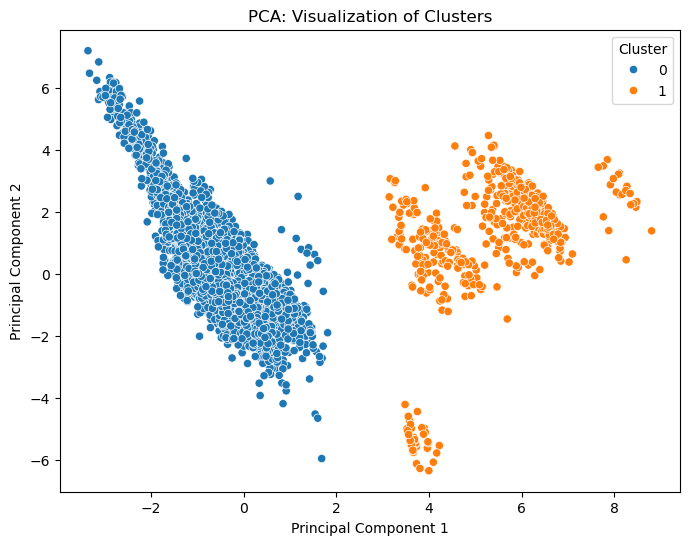

In [ ]:

#plot columns themselves 


# PCA Plot of Clusters
# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to DataFrame
viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
viz_df['Cluster'] = features['complication_label'].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=viz_df, x='PC1', y='PC2', hue='Cluster')
plt.title('PCA: Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


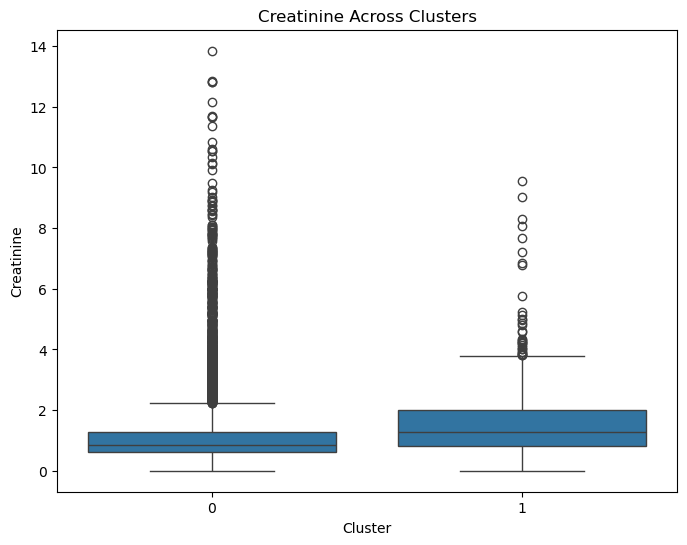

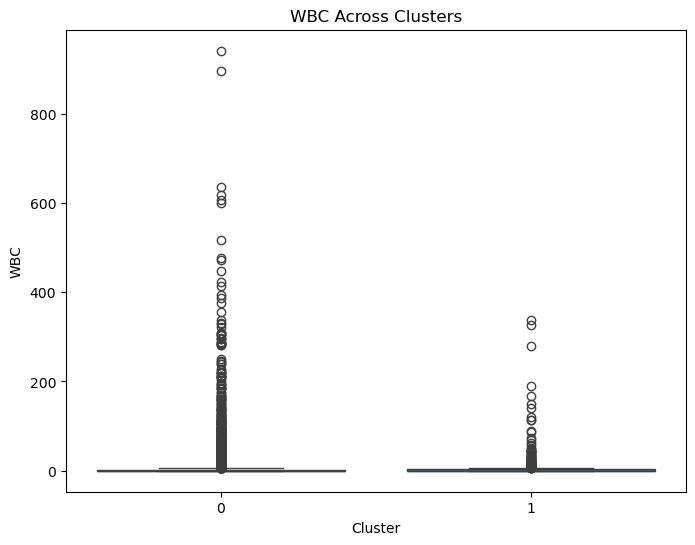

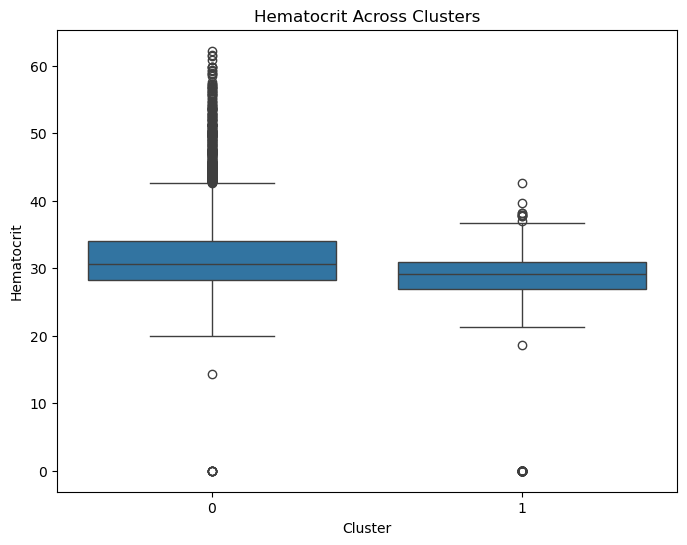

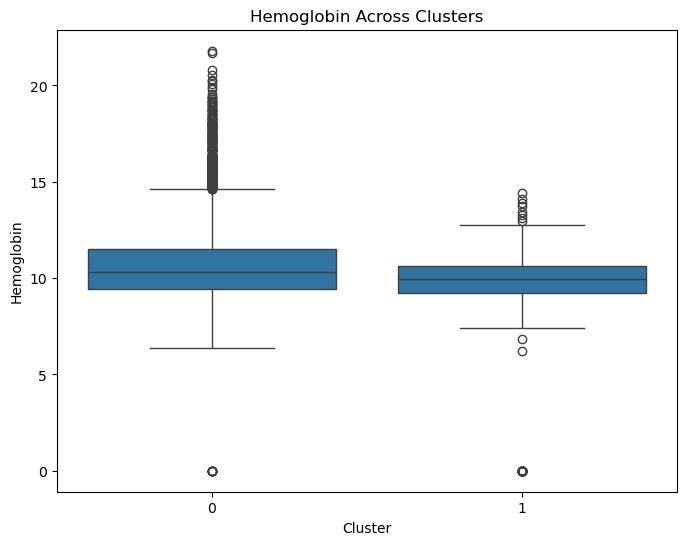

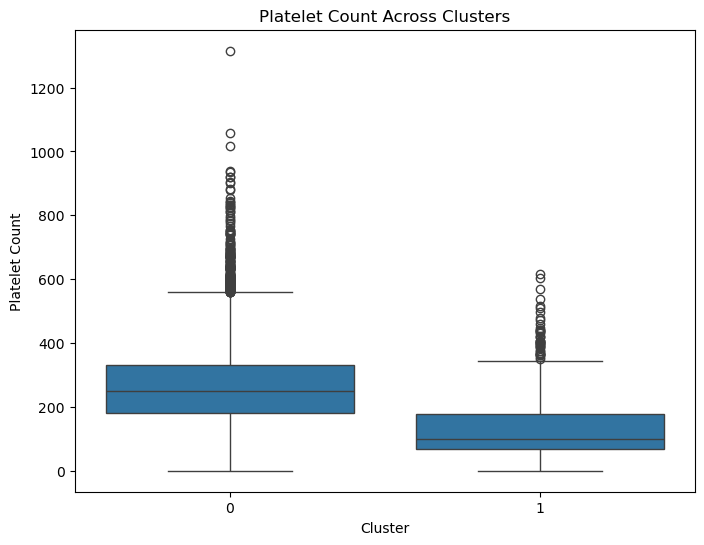

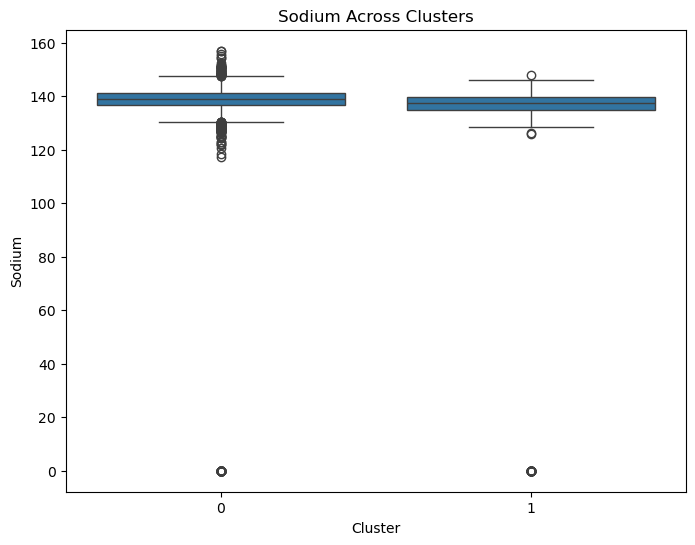

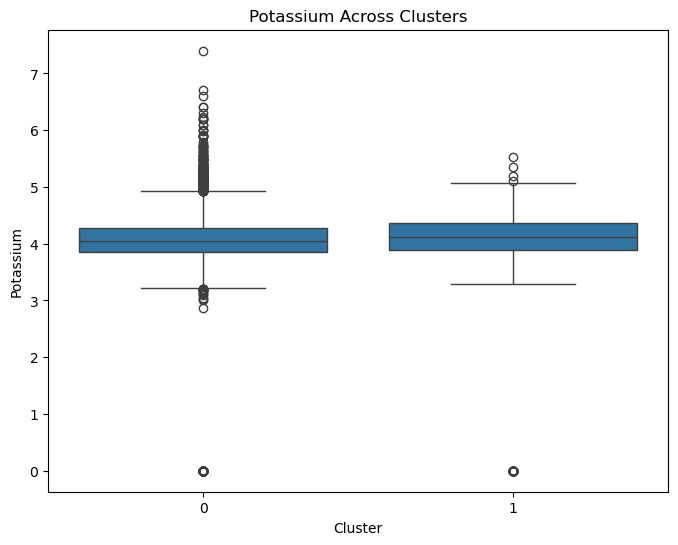

In [17]:
# Boxplots of Lab Values Across Clusters
lab_values = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'Sodium', 'Potassium']

for lab in lab_values:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='complication_label', y=lab, data=features)
    plt.title(f"{lab} Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel(lab)
    plt.show()


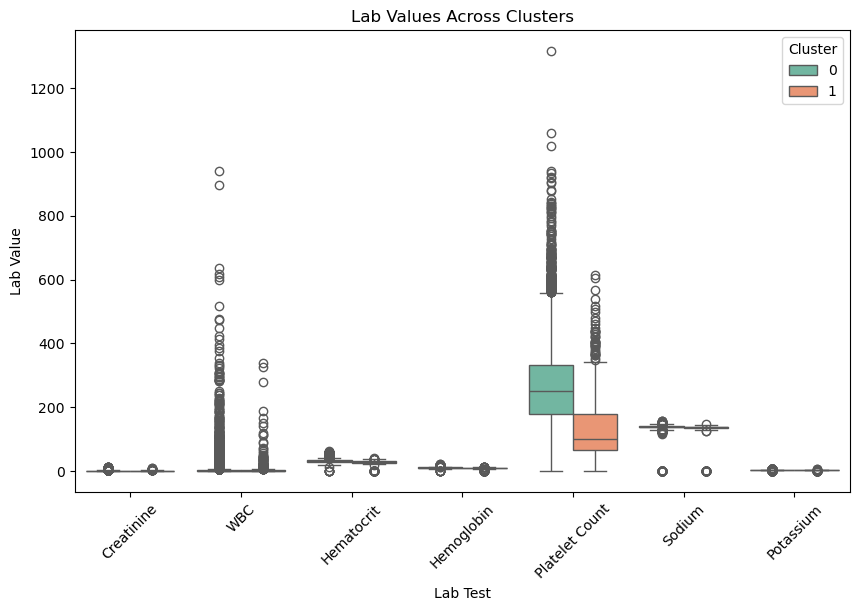

In [18]:
# Reshape the lab values data for combined boxplot
lab_values = ['Creatinine', 'WBC', 'Hematocrit', 'Hemoglobin', 'Platelet Count', 'Sodium', 'Potassium']

# Select the relevant lab columns and melt the dataframe
lab_data = features[['complication_label'] + lab_values]
lab_data = lab_data.melt(id_vars=['complication_label'], value_vars=lab_values, var_name='Lab', value_name='Value')

# Plot the combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lab', y='Value', hue='complication_label', data=lab_data, palette='Set2')
plt.title("Lab Values Across Clusters")
plt.xlabel("Lab Test")
plt.ylabel("Lab Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/3691584017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')


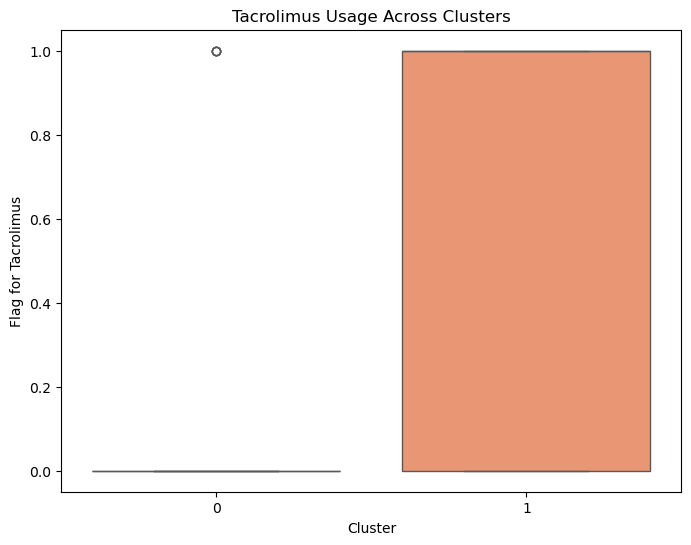

/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/3691584017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')


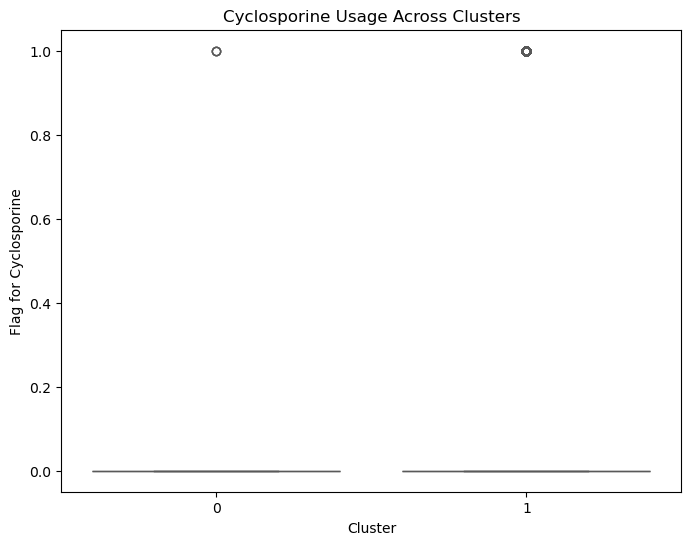

/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/3691584017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')


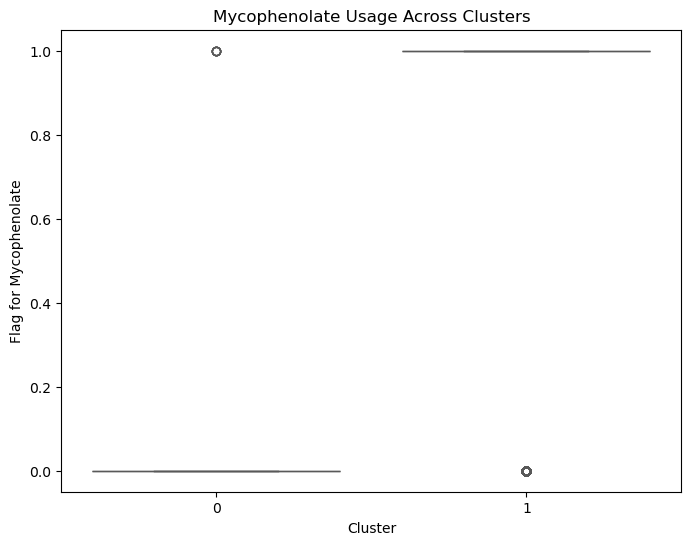

/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/3691584017.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')


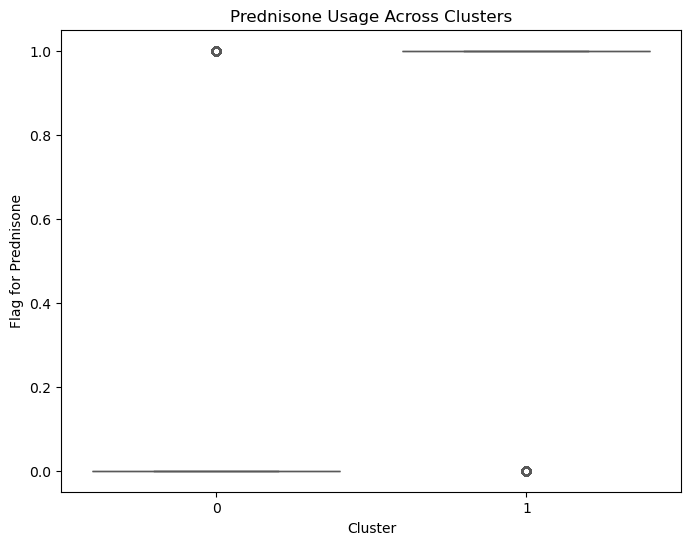

In [19]:
# Boxplots of Medication Usage Across Clusters
medications = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']

for med in medications:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='complication_label', y=med, data=features, palette='Set2')
    plt.title(f"{med.capitalize()} Usage Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel(f"Flag for {med.capitalize()}")
    plt.show()


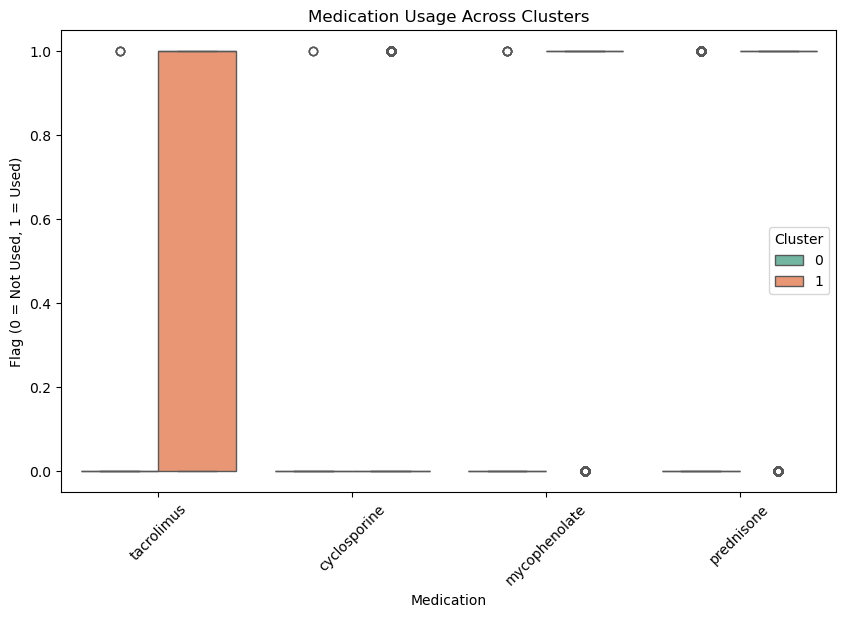

In [20]:
# Reshape the medication data for combined boxplot
medications = ['tacrolimus', 'cyclosporine', 'mycophenolate', 'prednisone']

# Select the relevant medication columns and melt the dataframe
med_data = features[['complication_label'] + medications]
med_data = med_data.melt(id_vars=['complication_label'], value_vars=medications, var_name='Medication', value_name='Flag')

# Plot the combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Medication', y='Flag', hue='complication_label', data=med_data, palette='Set2')
plt.title("Medication Usage Across Clusters")
plt.xlabel("Medication")
plt.ylabel("Flag (0 = Not Used, 1 = Used)")
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


In [21]:
'''# looking at length of stay to help determine categorization from clustering 

admissions = pd.read_csv("ADMISSIONS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "HOSPITAL_EXPIRE_FLAG"])

# Calculate length of stay
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])
admissions["DISCHTIME"] = pd.to_datetime(admissions["DISCHTIME"])
admissions["los"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)

# Merge with your features DataFrame
features = features.merge(admissions[["HADM_ID", "los", "HOSPITAL_EXPIRE_FLAG"]], on="HADM_ID", how="left")

# Mortality rate per cluster
mortality_by_cluster = features.groupby('complication_label')['HOSPITAL_EXPIRE_FLAG'].mean()
print("Mortality by Cluster:")
print(mortality_by_cluster)

# Length of stay by cluster
los_by_cluster = features.groupby('complication_label')['los'].mean()
print("\nAverage Length of Stay by Cluster:")
print(los_by_cluster)

# Optional: visualize
sns.boxplot(x='complication_label', y='los', data=features)
plt.title("LOS by Cluster")
plt.show()

sns.barplot(x='complication_label', y='HOSPITAL_EXPIRE_FLAG', data=features)
plt.title("Mortality Rate by Cluster")
plt.show()'''

'# looking at length of stay to help determine categorization from clustering \n\nadmissions = pd.read_csv("ADMISSIONS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "HOSPITAL_EXPIRE_FLAG"])\n\n# Calculate length of stay\nadmissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])\nadmissions["DISCHTIME"] = pd.to_datetime(admissions["DISCHTIME"])\nadmissions["los"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (60 * 60 * 24)\n\n# Merge with your features DataFrame\nfeatures = features.merge(admissions[["HADM_ID", "los", "HOSPITAL_EXPIRE_FLAG"]], on="HADM_ID", how="left")\n\n# Mortality rate per cluster\nmortality_by_cluster = features.groupby(\'complication_label\')[\'HOSPITAL_EXPIRE_FLAG\'].mean()\nprint("Mortality by Cluster:")\nprint(mortality_by_cluster)\n\n# Length of stay by cluster\nlos_by_cluster = features.groupby(\'complication_label\')[\'los\'].mean()\nprint("\nAverage Length of Stay by Cluster:")\nprint(los_by_cluster)\n

/var/folders/16/_1lsn7197mddy7lznxs1tqp00000gn/T/ipykernel_83061/2347362390.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=forest_importance[:15].values, y=forest_importance[:15].index, palette='viridis')


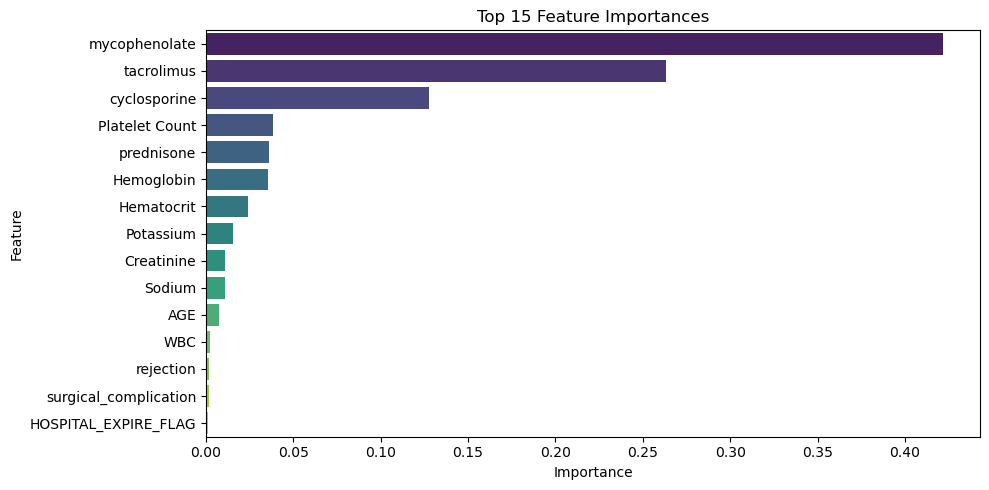

In [22]:
importances = clf.feature_importances_
feat_names = X.columns
forest_importance = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=forest_importance[:15].values, y=forest_importance[:15].index, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
